<a href="https://colab.research.google.com/github/kostarakonjac1331/AE-C-network/blob/main/AE%26C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTOVI


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Dense,LeakyReLU,BatchNormalization,Dropout,Input,MaxPool2D,Flatten,Activation
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import itertools
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import zipfile
import os
import random
import cv2

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#KONVOLUCIONI AUTOENCODER

Autoenkoderi sluze za kompresovanje i dekompresovanje podataka. Mozemo ih koristiti za skidanje suma sa slika, detekciju anomalija, kompresiju podataka za velike fajlove koje zelimo da skinemo, koji se posle dekompresuju na nasem uredjaju. Autoenkoderi se sastoje iz dva dela: enkoder (deo koji je zasluzan za kompresovanje podataka) i dekoder(deo koji je zasluzan za dekompresovanje podataka). U nasem slucaju nas enkoder se sastoji iz 2d konvolucionih slojeva i leakyReLu aktivacione funkcije sa padom od 0.001. Kada se prodje jedan konvolucioni sloj smanjuje se velicina slika za 2 puta. Dekoder se sastoji od 2d transponovanih konvolucionih slojeva i LeakyReLu aktivacija koje imaju isti pad kao i u enkoderu. 2d transponovani konvolucioni slojevi sluze za povecavanje dimenzija nase kompresovane slike i vracanje izgleda u prvobitno stanje. Na kraju imamo jedan 2d konvolucioni sloj koji sluzi da vratimo originalni oblik slike.




In [3]:
class AutoEncoder(Model):
  def __init__(self,input_shape):
    super(AutoEncoder,self).__init__()
    #encoder mreza
    self.encoder = keras.Sequential([
      Input(shape=input_shape),
      Conv2D(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001),
      Conv2D(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001)
    ])

    #decoder mreza
    self.decoder = keras.Sequential([
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001),
      Conv2DTranspose(64,kernel_size=3,strides=2,padding='same'),
      LeakyReLU(0.001),
      Conv2D(input_shape[2],kernel_size=3,padding='same'),
      LeakyReLU(0.001)
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




#KONVOLUCIONI KLASIFIKATOR

Nasa neuronska mreza za klasifikaciju se sastoji od 4 ciklusa 2d konvolucionih slojeva sa LeakyRelu aktivacijom ciji je pad 0.2. Posle svakog konvolucionog sloja imamo i dropout od 20%. Posle flatten sloja imamo guste slojeve koji takodje kao aktivacionu funkciju korste LeakyReLu ali imaju i sloj za batch normalizaciju. Batch normalizaciju koristimo za ubrzavanje ucenja nase mreze tako sto cemo normalizovati inpute nasih slojeva. Ovu mrezu smo kreirali pomocu keras subclassing api-a.

In [4]:
class CNNClasificator(Model):
  def __init__(self,number_of_classes):
    super(CNNClasificator,self).__init__()
    self.conv1 = Conv2D(16,kernel_size=3,padding='same')
    self.leaky1 = LeakyReLU(0.2)
    self.maxP1 = MaxPool2D()
    self.drop1 = Dropout(0.2)

    self.conv2 = Conv2D(32,kernel_size=3,padding='same')
    self.leaky2 = LeakyReLU(0.2)
    self.maxP2 = MaxPool2D()
    self.drop2 = Dropout(0.2)

    self.conv3 = Conv2D(64,kernel_size=3,padding='same')
    self.leaky3 = LeakyReLU(0.2)
    self.maxP3 = MaxPool2D()
    self.drop3 = Dropout(0.2)

    self.conv4 = Conv2D(128,kernel_size=3,padding='same')
    self.leaky4 = LeakyReLU(0.2)
    self.maxP4 = MaxPool2D()
    self.drop4 = Dropout(0.3)

    self.flat = Flatten()

    self.dense1 = Dense(512)
    self.leaky5 = LeakyReLU(0.2)
    self.drop5 = Dropout(0.3)
    self.batch1 = BatchNormalization()

    self.dense2 = Dense(128)
    self.leaky6 = LeakyReLU(0.2)
    self.drop6 = Dropout(0.3)
    self.batch2 = BatchNormalization()

    self.dense3 = Dense(64)
    self.leaky7 = LeakyReLU(0.2)
    self.drop7 = Dropout(0.2)
    self.batch3 = BatchNormalization()

    self.dense4 = Dense(number_of_classes)

  def call(self,x):
    x = self.leaky1(self.conv1(x))
    x = self.maxP1(x)
    x = self.drop1(x)

    x = self.leaky2(self.conv2(x))
    x = self.maxP2(x)
    x = self.drop2(x)

    x = self.leaky3(self.conv3(x))
    x = self.maxP3(x)
    x = self.drop3(x)

    x = self.leaky4(self.conv4(x))
    x = self.maxP4(x)
    x = self.drop4(x)

    x = self.flat(x)

    x = self.leaky5(self.dense1(x))
    x = self.drop5(x)
    x = self.batch1(x)

    x = self.leaky6(self.dense2(x))
    x = self.drop6(x)
    x = self.batch2(x)

    x = self.leaky7(self.dense3(x))
    x = self.drop7(x)
    x = self.batch3(x)

    x = self.dense4(x)

    return x



#AEC

Ova klasa sluzi kako bi objedinila autoenkoder i klasifikator. Za instanciranje ove klase potrebno je proslediti parametre za dataset koji zelimo da koristimo, dataset sa sumom za nas autoenkoder, oblikom naseg inputa i klasama naseg dataseta. Funkcije koja ova klasa ima su:

<li>Treniranje autoenkodera: <b>trainAutoEncoder()</b></li>
<li>Treniranje klasifikatora: <b>trainClasificator()</b></li>
<li>Skidanje suma sa slike: <b>encodingDecoding()</b></li>
<li>Predikcija klasifikatora: <b>clasifierPredict()</b></li>
<li>Prikazivanje prosecne greske klasifikatora: <b>plotLoss()</b></li>
<li>Prikazivanje preciznosti klasifikatora: <b>plotAccuracy()</b></li>
<li>Prikazivanje matrice konfuzije za nas klasifikator: <b>plot_confusion_matrix()</b></li>

In [5]:
class AEC:
  def __init__(self,train_data,test_data,train_labels,test_labels,noisy_train,noisy_test,input_shape,classes):
    self.train_data = train_data
    self.test_data = test_data
    self.train_labels = train_labels
    self.test_labels = test_labels
    self.noisy_test = noisy_test
    self.noisy_train = noisy_train
    self.classes = classes
    self.autoencoder = AutoEncoder(input_shape)
    self.clasificator = CNNClasificator(len(classes))
    self.history = None
    self.predictions = None
  

  def trainAutoEncoder(self):
    self.autoencoder.compile(optimizer='adam',loss=keras.losses.MeanSquaredError())

    self.autoencoder.fit(self.noisy_train, self.train_data,
                epochs=10,
                shuffle=True)
    print(self.autoencoder.encoder.summary())
    print(self.autoencoder.decoder.summary())



  def trainClasificator(self):
    self.clasificator.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=["accuracy"],
    )
    self.history = self.clasificator.fit(self.train_data, self.train_labels, batch_size=128, epochs=100, verbose=2,validation_data=(self.test_data,self.test_labels))
    self.predictions = np.argmax(self.clasificator.predict(x=self.test_data, batch_size=128, verbose=0),axis=1)

  def clasifierPredict(self,picture):
    picture = tf.expand_dims(input=picture,axis=0)
    predikcija = self.clasificator.predict(x=picture,batch_size=64)
    roundPredikcija = np.argmax(predikcija)
    return roundPredikcija

  def plotAccuracy(self):
    plt.plot(self.history.history['accuracy'], label='accuracy')
    plt.plot(self.history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
  
  def plotLoss(self):
    plt.plot(self.history.history['loss'], label='loss')
    plt.plot(self.history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 3])
    plt.legend(loc='lower right')

    test_loss, test_acc = self.clasificator.evaluate(self.test_data, self.test_labels, verbose=2)


  def plot_confusion_matrix(self,target_names,title='Matrica konfuzije',cmap=None,normalize=True):
    cm = confusion_matrix(y_true=self.test_labels, y_pred=self.predictions)
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
      cmap = plt.get_cmap('magma')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)

    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thtest_labelsresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="red")
      else:
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="red")


    plt.tight_layout()
    plt.ylabel('Tacne klase')
    plt.xlabel('Prediktovane klase\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


  def encodingDecoding(self,picture):
    picture = tf.expand_dims(input = picture, axis = 0)
    enc = self.autoencoder.encoder(picture)
    dec = self.autoencoder.decoder(enc)

    return dec

    

In [6]:
def rezultat_treniranja_ae():
  print("rezultat treniranja: \n")
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
    cleaned = model.encodingDecoding(x_test_noisy[i])
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("rekonstruisana")
    plt.imshow(tf.squeeze(cleaned))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
  plt.show()

#Ucitavanje prvog dataseta: CIFAR10

Cifar10 se sastoji od 60000 slika koje su dimenzija 32X32 sa 3 color channela.

In [7]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()



x_train = x_train.astype("float32") /255.0
x_test = x_test.astype("float32") / 255.0

noise_factor = 0.15
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

x_test.shape

(10000, 32, 32, 3)

#Klase CIFAR10 dataseta

In [8]:
classNames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [9]:
model = AEC(x_train,x_test,y_train,y_test,x_train_noisy,x_test_noisy,classes=classNames,input_shape=(32,32,3))

Epoch 1/10
1563/1563 [==============================] - 12s 6ms/step - loss: 0.0152
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0032
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0030
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0029
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0028
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0027
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0027
Epoch 8/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0027
Epoch 9/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0027
Epoch 10/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0026
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


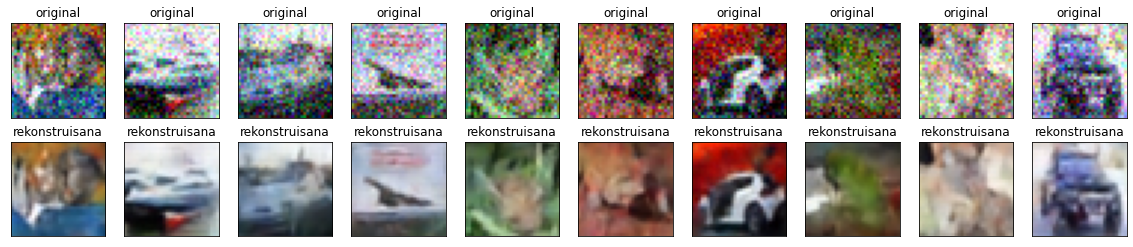

In [10]:
model.trainAutoEncoder()
rezultat_treniranja_ae()

In [11]:
model.trainClasificator()

Epoch 1/100
391/391 - 5s - loss: 2.2738 - accuracy: 0.2090 - val_loss: 2.0527 - val_accuracy: 0.2687
Epoch 2/100
391/391 - 2s - loss: 1.8092 - accuracy: 0.3312 - val_loss: 1.6322 - val_accuracy: 0.3908
Epoch 3/100
391/391 - 2s - loss: 1.5987 - accuracy: 0.4100 - val_loss: 1.5531 - val_accuracy: 0.4249
Epoch 4/100
391/391 - 2s - loss: 1.4746 - accuracy: 0.4575 - val_loss: 1.3902 - val_accuracy: 0.4896
Epoch 5/100
391/391 - 2s - loss: 1.3830 - accuracy: 0.4956 - val_loss: 1.3565 - val_accuracy: 0.5042
Epoch 6/100
391/391 - 2s - loss: 1.3160 - accuracy: 0.5242 - val_loss: 1.3324 - val_accuracy: 0.5239
Epoch 7/100
391/391 - 2s - loss: 1.2547 - accuracy: 0.5504 - val_loss: 1.1626 - val_accuracy: 0.5827
Epoch 8/100
391/391 - 2s - loss: 1.2097 - accuracy: 0.5661 - val_loss: 1.2800 - val_accuracy: 0.5532
Epoch 9/100
391/391 - 2s - loss: 1.1659 - accuracy: 0.5841 - val_loss: 1.1883 - val_accuracy: 0.5866
Epoch 10/100
391/391 - 2s - loss: 1.1240 - accuracy: 0.5980 - val_loss: 1.0319 - val_accura

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


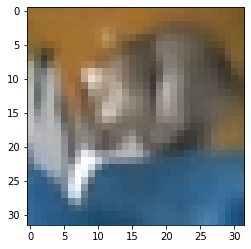

In [12]:
dc = model.encodingDecoding(x_test[0])
plt.imshow(tf.squeeze(dc))


In [13]:
print(x_test[0].size)

3072


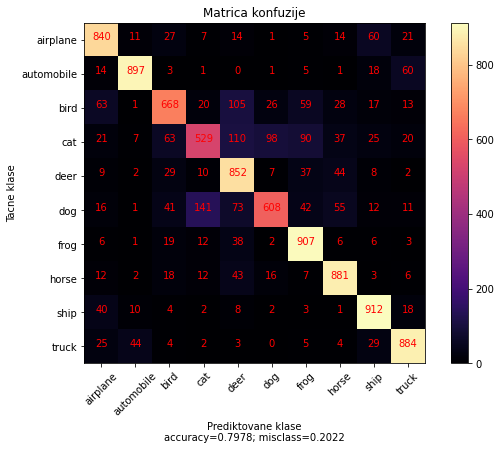

In [14]:
model.plot_confusion_matrix(target_names=classNames, title="Matrica konfuzije", normalize=False)

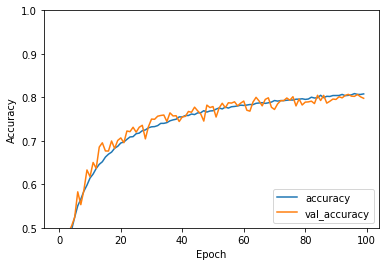

In [15]:
model.plotAccuracy()

313/313 - 1s - loss: 0.5991 - accuracy: 0.7978


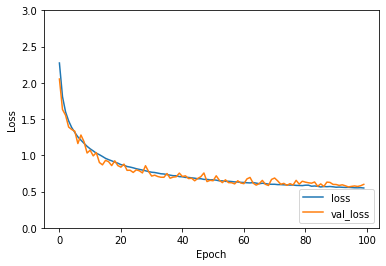

In [16]:
model.plotLoss()

#Prikaz procenta tacnosti klasifikatora pre preciscavanja slika

In [17]:
def procenat_tacnosti_pre_ciscenja():
  broj_tacnih_predikcija = 0

  for i in range(int(x_test.size/x_test[0].size)):
    predikcija = model.clasifierPredict(x_test_noisy[i])
    if(predikcija == y_test[i]):
      broj_tacnih_predikcija+=1
      
  procenat_tacnosti = broj_tacnih_predikcija/y_test.size

  labels = 'Tacne predikcije', 'Netacne predikcije'
  sizes = [procenat_tacnosti*100. ,(1-procenat_tacnosti)*100]
  explode = (0, 0.1)  

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, explode = explode, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  ax1.axis('equal') 

  plt.show()

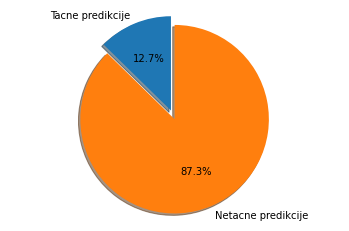

In [18]:
procenat_tacnosti_pre_ciscenja()

#Prikaz procenta tacnosti klasifikatora posle preciscavanja slika

In [53]:
def procenat_tacnosti_posle_ciscenja():
  broj_tacnih_predikcija = 0
  for i in range(int(x_test.size/x_test[0].size)):
    predikcija = model.clasifierPredict(tf.squeeze(model.encodingDecoding(x_test_noisy[i])))
    if(predikcija == y_test[i]):
      broj_tacnih_predikcija+=1
      
  procenat_tacnosti = broj_tacnih_predikcija/y_test.size

  labels = 'Tacne predikcije', 'Netacne predikcije'
  sizes = [procenat_tacnosti*100. ,(1-procenat_tacnosti)*100]
  explode = (0, 0.1)  

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  ax1.axis('equal') 

  plt.show()




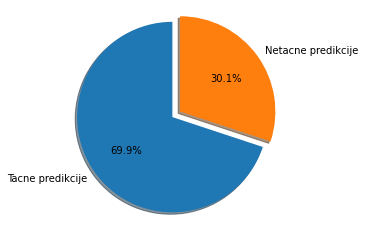

In [20]:
procenat_tacnosti_posle_ciscenja()

#Ucitavanje drugog dataseta: FASHON MNIST

Fashon mnist dataset se sastoji od 60000 slika koje su dimenzija 28X28 sa jednim color channelom.

In [21]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32") /255.0
x_test = x_test.astype("float32") / 255.0

x_train = tf.expand_dims(input = x_train,axis = 3)
x_test = tf.expand_dims(input = x_test,axis = 3)

noise_factor = 0.25
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

x_test.shape

TensorShape([10000, 28, 28, 1])

#Klase fashon mnist dataseta

In [22]:
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]


In [23]:
model = AEC(x_train,x_test,y_train,y_test,x_train_noisy,x_test_noisy,classes=class_names,input_shape=(28,28,1))

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0180
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0071
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0067
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0066
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0064
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0064
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0063
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0062
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0062
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0061
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2

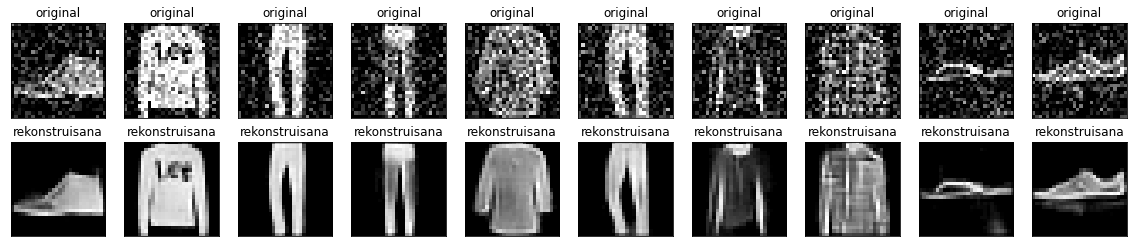

In [24]:
model.trainAutoEncoder()
rezultat_treniranja_ae()

In [25]:
model.trainClasificator()

Epoch 1/100
469/469 - 4s - loss: 1.0940 - accuracy: 0.6018 - val_loss: 1.0110 - val_accuracy: 0.7750
Epoch 2/100
469/469 - 2s - loss: 0.6182 - accuracy: 0.7718 - val_loss: 0.4562 - val_accuracy: 0.8242
Epoch 3/100
469/469 - 2s - loss: 0.5171 - accuracy: 0.8138 - val_loss: 0.4134 - val_accuracy: 0.8449
Epoch 4/100
469/469 - 2s - loss: 0.4638 - accuracy: 0.8320 - val_loss: 0.3774 - val_accuracy: 0.8613
Epoch 5/100
469/469 - 2s - loss: 0.4271 - accuracy: 0.8457 - val_loss: 0.3527 - val_accuracy: 0.8685
Epoch 6/100
469/469 - 2s - loss: 0.3980 - accuracy: 0.8565 - val_loss: 0.3351 - val_accuracy: 0.8774
Epoch 7/100
469/469 - 2s - loss: 0.3787 - accuracy: 0.8636 - val_loss: 0.3330 - val_accuracy: 0.8768
Epoch 8/100
469/469 - 2s - loss: 0.3630 - accuracy: 0.8690 - val_loss: 0.3062 - val_accuracy: 0.8881
Epoch 9/100
469/469 - 2s - loss: 0.3486 - accuracy: 0.8746 - val_loss: 0.2994 - val_accuracy: 0.8900
Epoch 10/100
469/469 - 2s - loss: 0.3377 - accuracy: 0.8780 - val_loss: 0.2904 - val_accura

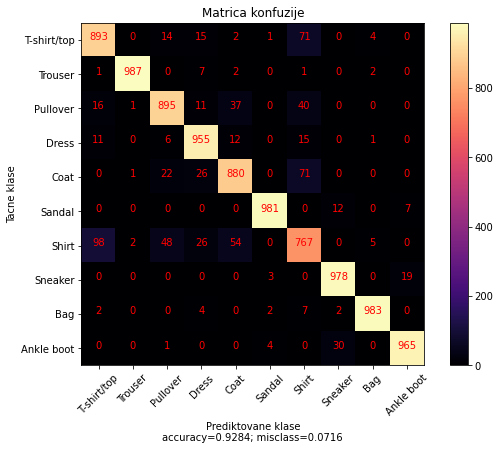

In [26]:
model.plot_confusion_matrix(target_names=class_names, title="Matrica konfuzije", normalize=False)

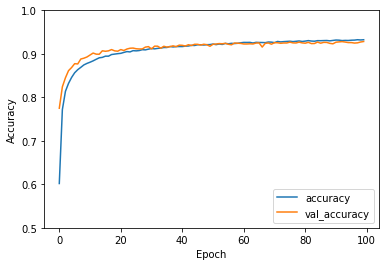

In [27]:
model.plotAccuracy()

313/313 - 1s - loss: 0.2057 - accuracy: 0.9284


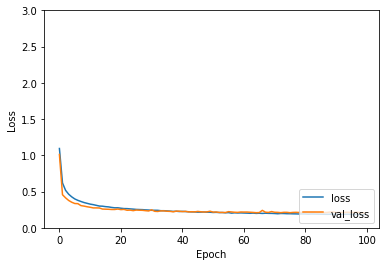

In [28]:
model.plotLoss()

In [29]:
len(x_test)

10000

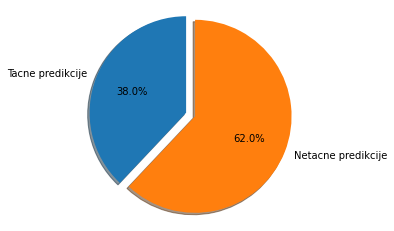

In [31]:
x_test = x_test.numpy()
procenat_tacnosti_pre_ciscenja()

In [32]:
x_test_noisy[0].shape


TensorShape([28, 28, 1])

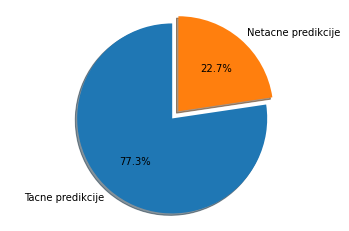

In [54]:
procenat_tacnosti_posle_ciscenja()

#CATS VS DOGS DATASET


In [34]:
train_ds = tfds.load('cats_vs_dogs', split='train')

In [35]:
def preprocess(features):
  image = tf.image.resize(features['image'], [64,64])
  image = tf.divide(image, 255)
  label = features['label']
  return image, tf.cast(label, tf.float32)

In [36]:
train_x = train_ds.as_numpy_iterator()
x_train = []
y_train = []

x_test = []
y_test = []

split = int(len(train_ds)*0.8)
brojac = 0
for i in train_x:
  if (brojac>split):
    a = preprocess(i)
    x_test.append(a[0])
    y_test.append(a[1])
  else:
    a = preprocess(i)
    x_train.append(a[0])
    y_train.append(a[1])
    brojac+=1




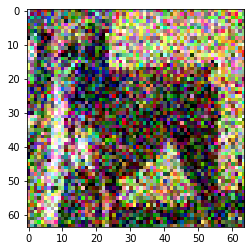

In [37]:
x_train = np.array(x_train)
x_test = np.array(x_test)

noise_factor = 0.25
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)  

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

plt.imshow(x_train_noisy[0])

 




In [38]:
y_test = np.array(y_test)
y_train = np.array(y_train)

In [39]:
print(y_test[0])

0.0


In [40]:
class_names = ["DOG","CAT"]

In [41]:
model = AEC(x_train,x_test,y_train,y_test,x_train_noisy,x_test_noisy,classes=class_names,input_shape=(64,64,3))

Epoch 1/10
582/582 [==============================] - 11s 17ms/step - loss: 0.0289
Epoch 2/10
582/582 [==============================] - 10s 16ms/step - loss: 0.0068
Epoch 3/10
582/582 [==============================] - 10s 17ms/step - loss: 0.0060
Epoch 4/10
582/582 [==============================] - 10s 17ms/step - loss: 0.0058
Epoch 5/10
582/582 [==============================] - 10s 17ms/step - loss: 0.0056
Epoch 6/10
582/582 [==============================] - 10s 17ms/step - loss: 0.0056
Epoch 7/10
582/582 [==============================] - 10s 17ms/step - loss: 0.0055
Epoch 8/10
582/582 [==============================] - 10s 17ms/step - loss: 0.0054
Epoch 9/10
582/582 [==============================] - 10s 17ms/step - loss: 0.0054
Epoch 10/10
582/582 [==============================] - 10s 17ms/step - loss: 0.0053
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv

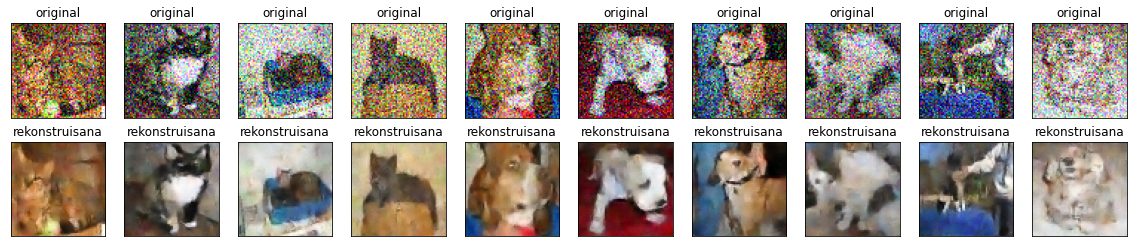

In [42]:
model.trainAutoEncoder()
rezultat_treniranja_ae()

In [43]:
model.trainClasificator()

Epoch 1/100
146/146 - 4s - loss: 0.9307 - accuracy: 0.5136 - val_loss: 0.6938 - val_accuracy: 0.5067
Epoch 2/100
146/146 - 2s - loss: 0.8114 - accuracy: 0.5248 - val_loss: 0.6829 - val_accuracy: 0.5761
Epoch 3/100
146/146 - 2s - loss: 0.7709 - accuracy: 0.5371 - val_loss: 0.6930 - val_accuracy: 0.5144
Epoch 4/100
146/146 - 2s - loss: 0.7173 - accuracy: 0.5778 - val_loss: 0.6683 - val_accuracy: 0.6103
Epoch 5/100
146/146 - 2s - loss: 0.6778 - accuracy: 0.6094 - val_loss: 0.6426 - val_accuracy: 0.6434
Epoch 6/100
146/146 - 2s - loss: 0.6417 - accuracy: 0.6436 - val_loss: 0.6220 - val_accuracy: 0.6518
Epoch 7/100
146/146 - 2s - loss: 0.6122 - accuracy: 0.6652 - val_loss: 0.6015 - val_accuracy: 0.6610
Epoch 8/100
146/146 - 2s - loss: 0.5825 - accuracy: 0.6973 - val_loss: 0.5577 - val_accuracy: 0.7190
Epoch 9/100
146/146 - 2s - loss: 0.5521 - accuracy: 0.7193 - val_loss: 0.5121 - val_accuracy: 0.7524
Epoch 10/100
146/146 - 2s - loss: 0.5243 - accuracy: 0.7427 - val_loss: 0.5216 - val_accura

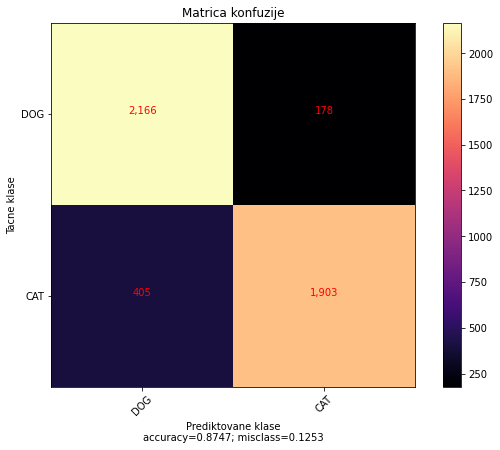

In [44]:
model.plot_confusion_matrix(target_names=class_names, title="Matrica konfuzije", normalize=False)

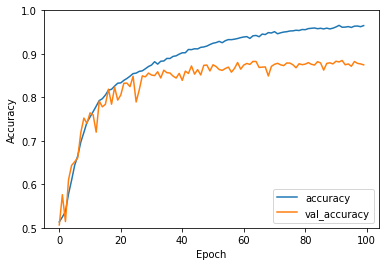

In [45]:
model.plotAccuracy()

146/146 - 1s - loss: 0.4053 - accuracy: 0.8747


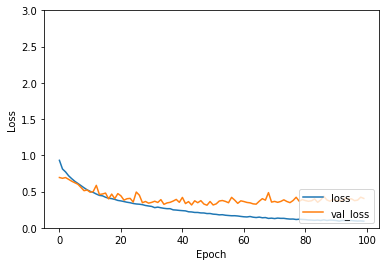

In [46]:
model.plotLoss()

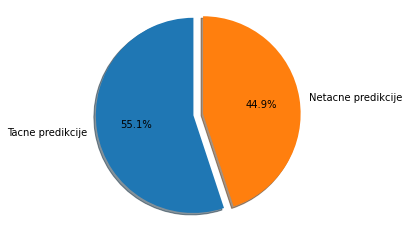

In [48]:
procenat_tacnosti_pre_ciscenja()

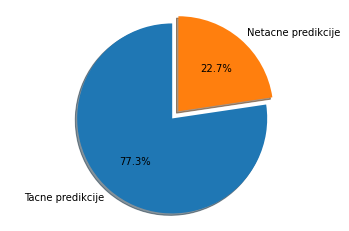

In [49]:
procenat_tacnosti_posle_ciscenja()